# Using the logistic encoder to represent any GGA libxc exchange functional with just 1 parameter

Take any GGA exchange functional from libXC and represent its enhancement factor on a grid (containing npoints). Then find the initial conditon $\alpha$ such that the enhancement factor can be reproduced using the logistic decoder:

$$
\begin{equation}
f(x) = \sin^2 ( 2^{x\beta} \arcsin \sqrt \alpha )
\end{equation}
$$

with $\beta$ controlling the accuracy of the encoding process.
The accuracy of the interpolation depends on the number of grid points (npoints).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylibxc as pylibxc
import scipy.interpolate as spint

#Awtting the most important parameters, the number of points and the functional. beta is set in helperFunctions.py
npoints=100
functional='gga_x_pbe'

In [2]:
#reading the functionals from libxc

#defining the transformation of s into u and the corresponding backtransformation
# uu is taking a variable u ∈ [0,∞] and transforms it into u ∈ [0,1]. ss is the backtransformation of u into s.
# g is a compression parameter useful to weigh some regions of the range more than others (default=1)
# inf is to avoid discontinuities for the point at u=1 (s=infinity):
inf=0.00000001
gamma=1
uu = lambda s,g: g*(s**2+inf*s**2)/(1+g*s**2);
ss = lambda u,g: (u/(g+g*inf-g*u))**(1/2);

#select libxc functional
flda = pylibxc.LibXCFunctional("lda_x", "unpolarized")
func = pylibxc.LibXCFunctional(functional, "unpolarized")

rss=0.5
#density values, in its terms of the Wigner-Seitz radius (rss)
rhoval=3/(4*np.pi*(rss**3))

fxval = []
for x in range(npoints+1):
    #calculate s from u(=x/npoint), using the transformation defined above.
    spv=ss(x/npoints,gamma)
    #libxc requires gradrho=gam instead of s as an input
    gam=(rhoval**(4/3)*spv/(24*np.pi**2)**(-1/3))**2
    inp = {}
    inp["rho"] = [rhoval]
    inp["sigma"] = [gam]
    fval = func.compute(inp)
    lval = flda.compute(inp)
    zk=np.ndarray.flatten(list(fval.values())[0])
    zlda=np.ndarray.flatten(list(lval.values())[0])
    fx = zk/zlda;
    fxval.append(fx);

fxval=np.concatenate(fxval).ravel()

#patch to avoid functional that diverge at s=infinity to explode at u=1. If we don't do this, the fit error will be dominated by this last point
rescale=False;
if fxval[npoints]>100:
    fxval[npoints]=fxval[npoints-1]*2
    rescale=True
    print('Warning: %s diverges at s=infinity.' % functional)
    print('Applying a patch to avoid explosion of errors')  

In [3]:
#select one array/functional:
xxs=fxval

#normalize all data to y=[0,1] interval

from sklearn.preprocessing import MinMaxScaler

allData = np.array(xxs).reshape(-1, 1)
normalizerModel = MinMaxScaler().fit(allData)
xs = normalizerModel.transform(allData)
originalDataSize = allData.shape[0]

#print('alldata = %s' % xxs)
#print('alldata = %s' % xs)

In [4]:
#Call the logistic encoder to encode data to 1 parameter (beta is set in helperFunctions and is defaulted at 8)
from helperFunctions import *

decimalInitial = findInitialCondition(xs)

#Printing the single parameter:
print(decimalInitial)
print('\nbeta = %d' % beta)
print('number of decimal digits = %d' % len(str(decimalInitial)))


significance = 1212 bits ; 364 digits (base-10) ; ratio = 3.330

0.0000000001622471933881838685312475106447084288365603101923246140299260944973616873896087094063413651157926050554149174037341664856101506533525102249245224624901388277733692949249702044048112277359319762117412090849444986399661885278365520092964921112011876835381810224460640286420009210653924828790320267195770843782587106736205234810687869541284298190283704356125446501368

beta = 12
number of decimal digits = 375


In [5]:
#Call the inverse transformation for decode the data
decodedValues = generateData(decimalInitial, originalDataSize)
#print('data before transformation = %s' % decodedValues)

In [6]:
#Rescale the values back to the original y range

decodedValuesR = np.array(decodedValues).reshape(-1, 1)
decodedValuesR = normalizerModel.inverse_transform(decodedValuesR)
decodedValuesR = np.concatenate(decodedValuesR).ravel()

#print('data after transformation = %s' % decodedValues)

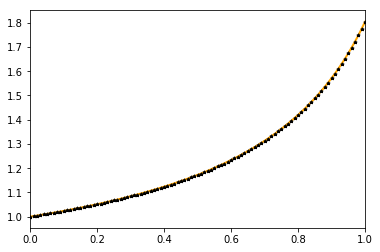

In [7]:
#plotting the original and decoded data

xaxis=[]
for x in range(npoints+1):
    xaxis.append(x/npoints);


plt.plot(xaxis, xxs, color='orange', lw=2, zorder=1)
plt.scatter(xaxis, decodedValuesR, color='black', marker='*', s=10, zorder=2)
plt.xlim(0,1)
if rescale == True:    
    plt.ylim(0.9,4)
plt.show()
#from matplotlib import pyplot as mp
#mp.savefig('resources/codeExamples/decodedValues_logistic1.png')

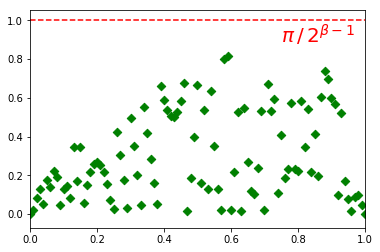

In [8]:
#Analyze the error
MaxError=np.pi/ 2 ** (beta - 1)
#MaxError=1/2**beta
#print(MaxError)

Errors = [abs(decodedValue - dataPoint)
                    for decodedValue, dataPoint in zip(decodedValues, xs)]
error=sum(Errors);
maxerror=max(Errors);
#print(Errors)
normalizedErrors = [abs(decodedValue - dataPoint)/MaxError
                    for decodedValue, dataPoint in zip(decodedValues, xs)]

plt.scatter(xaxis, normalizedErrors, color='green', marker='D')
#plt.ylim(-0.05,20)
plt.hlines(1, 0, 1, color='red', linestyle='dashed')
plt.text(0.75,0.88, r'$\pi \, / \, 2^{\beta - 1}$', fontsize=20, color='r')
plt.xlim(0,1)
plt.show()

#print('MaxError = %g' % sum(normalizedErrors));

In [9]:
#interpolation
intrange=1001 # number of points used to evaluate the error
smoothing=0   # smoothing of the spline interpolation (pick 0 to interpolate all points)

#interpolate the functional using the npoints (select what to interpolate here)
gcubOV = spint.interp1d(xaxis, xxs, kind='cubic') # cubic spline interpolation for the libXC functional
gcub   = spint.interp1d(xaxis, decodedValuesR, kind='cubic') # cubic spline interpolation for the decoded values
splcubOV = spint.UnivariateSpline(xaxis, xxs, s=smoothing) # univariate spline interpolation for the libXC functional
splcub = spint.UnivariateSpline(xaxis, decodedValuesR, s=smoothing) # Univariate spline interpolation for the decoded values

# pick an interpolation method:
interp=splcub

#Use libxc again to calculate the functional on a new finer grid xnew
xnew = np.linspace(0, 1,intrange)    
    
spv=ss(xnew,gamma)
gam=(rhoval**(4/3)*spv/(24*np.pi**2)**(-1/3))**2
inp = {}
inp["rho"] = [rhoval for i in range(intrange)]
inp["sigma"] = [gam]
fval = func.compute(inp)
lval = flda.compute(inp)
zk=np.ndarray.flatten(list(fval.values())[0])
zlda=np.ndarray.flatten(list(lval.values())[0])
fx = zk/zlda;
if rescale==True:
    print('Warning: patching functional and interpolate only up to u = 0.95 to avoid divergence at s=infinity.')


#rescaling back from u to s and replot
xaxisR=[ss(x,gamma) for x in xaxis]
xnewR=[ss(x,gamma) for x in xnew]

#reinterpolate the functional on the new range
gcubOVR = spint.interp1d(xaxisR, xxs, kind='cubic')
gcubR   = spint.interp1d(xaxisR, decodedValuesR, kind='cubic')
splcubOVR = spint.UnivariateSpline(xaxisR, xxs, s=smoothing)
splcubR = spint.UnivariateSpline(xaxisR, decodedValuesR, s=smoothing)

# pick an interpolation method:
interpR=splcubR




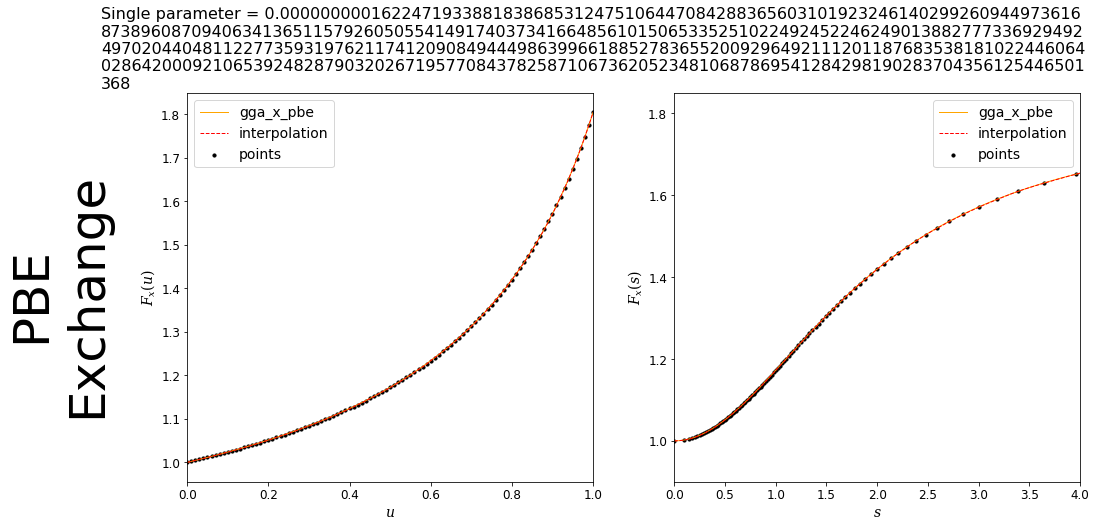


Total interpolation error = 0.00297412


In [15]:
#plot printout
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams["figure.figsize"] = [16,8]
import textwrap
fig = plt.figure()
fig.suptitle("\n".join(textwrap.wrap(str('Single parameter = {}'.format(decimalInitial)), width = 100,subsequent_indent='   ')),  x=0.05, y=.95, ha='left', wrap=True)
fig.subplots_adjust(top=0.8)

fig.text(0.05, 0.45, "PBE\nExchange", ha='center', rotation=90, size=50, Wrap=True)

#Plot the interpolation vs the functional and the original points
plt.subplot(1, 2,1)
plt.scatter(xaxis, xxs, color='black', marker='o',s=10, zorder=0,label='points')
plt.plot(xnew,fx,  color='orange', lw=1, zorder=1, label=functional)
plt.plot(xnew,interp(xnew), '--', color='red',lw=1, zorder=2, label='interpolation')
plt.legend(loc = 'upper left')
plt.xlim(0,1)
if rescale==True:
    plt.ylim(0.9,2)
plt.xlabel('$u$')
plt.ylabel('$F_{x}(u)$')

#Plot the interpolation vs the functional and the original points
plt.subplot(1, 2,2)
plt.scatter(xaxisR, xxs, color='black', marker='o',s=10, zorder=0,label='points')
plt.plot(xnewR,fx,  color='orange', lw=1, zorder=1, label=functional)
plt.plot(xnewR,interpR(xnewR), '--', color='red',lw=1, zorder=2, label='interpolation')
plt.xlim(0,4)
plt.legend(loc = 'best')
plt.ylim(0.9,1.85)
plt.xlabel('$s$')
plt.ylabel('$F_{x}(s)$')

#plt.savefig('GGA_PBE_X.png',dpi=480,bbox_inches="tight")

plt.show()


#Calculate the interpolation error on the finer grid
interpErr=[]
#for sss in range(intrange):
#    interpErr.append(abs((fx[sss] - interp((sss)/(intrange-1)))/fx[sss]))

for sss in range(intrange):
    if abs((fx[sss] - interp((sss)/(intrange-1)))/fx[sss]) <=100: #this is here because sometimes the error
        interpErr.append(abs((fx[sss] - interp((sss)/(intrange-1)))/fx[sss]))
#        print(sss,fx[sss],interp((sss)/(intrange-1)),sum(interpErr))

if rescale==True:
    interpErr=interpErr[:-50] # calculate interpolation error only up to s=0.95 for ill-behaved functionals
    
    
totinterr=sum(interpErr)/npoints;

    
print('\nTotal interpolation error = %g' % totinterr)


In [11]:
#Final printout
#totinterr is the normalized interpolation error (normalized by the total number of points in the grid)
# this is mostly affected by the npoints parameter
totinterr=sum(interpErr)/npoints;
#totencerr is the normalized error of the encoder rescaled back to the original y range (using a pessimistic multiplication by the max value in the range, so this is really an upper bound to the error)
# this is mostly affected by the beta parameter
totencerr=sum(Errors)*max(xxs);
#toterr is the sum of the previous errors, which is a good indication of the success of the procedure
toterr=totinterr+totencerr;


print('Functional = %s' % functional)
print('Single parameter = {}'.format(decimalInitial))

if rescale == True:
    print('\nWarning: %s diverges at s=infinity. The errors might be affected, particularly the interpolation! Use caution when interpreting the next results.' % functional)

print('\nnpoints = %d' % npoints)
print('Interpolation error = %g' % totinterr)
print('\nbeta = %d' % beta)
print('Encoder error = %g' % totencerr)
print('\nTotal error = %g' % toterr)

Functional = gga_x_pbe
Single parameter = 0.0000000001622471933881838685312475106447084288365603101923246140299260944973616873896087094063413651157926050554149174037341664856101506533525102249245224624901388277733692949249702044048112277359319762117412090849444986399661885278365520092964921112011876835381810224460640286420009210653924828790320267195770843782587106736205234810687869541284298190283704356125446501368

npoints = 100
Interpolation error = 0.00297412

beta = 12
Encoder error = 0.0827142

Total error = 0.0856883
